In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# Modified for NR segmentation and measurement

# Automatically generating object masks with SAM

Since SAM can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image. This method was used to generate the dataset SA-1B.

The class `SamAutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

In [1]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/htao7/sam_nr/blob/main/main.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [2]:
using_colab = True

In [3]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !wget -c https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
    !wget -c https://github.com/htao7/sam_nr/raw/main/nr.jpg

PyTorch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-71uozynq
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-71uozynq
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=f779610542bfbcda7773dddae1492130a1231bc78ea76e4b2fbed4d84b01aab6
  Stored in directory: /tmp/pip-ephem-wheel-cache-412f6h94/wheels/15/d7/bd/05f5f23b7dcbe70cbc6783b06f12143b0cf1a5da5c7b52dcc5
Successfully built segment_anything
--2025-06-11 04:10:40--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.227.219.59, 13.227.219.70, 

## Set-up

In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

## Example image

In [5]:
image = cv2.imread('nr.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

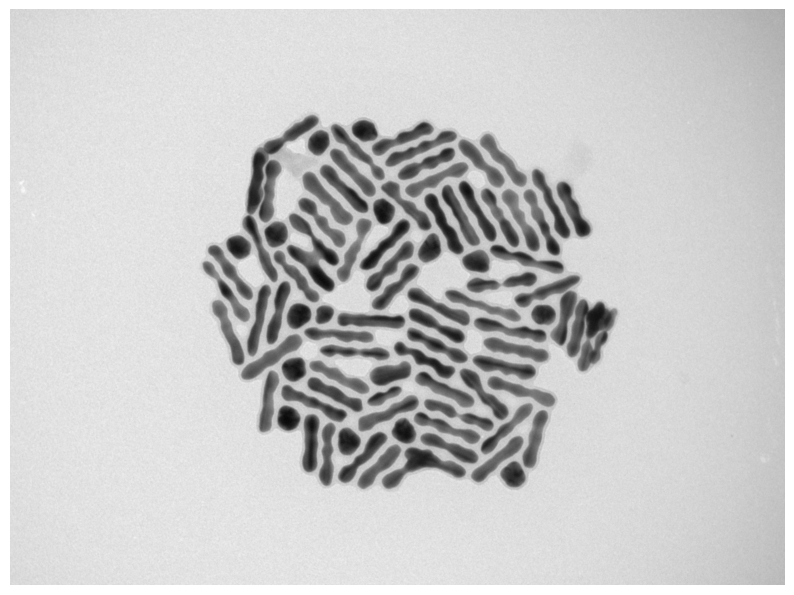

In [6]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('off')
plt.show()

## Automatic mask generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [7]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.85,
    stability_score_thresh=0.92,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

To generate masks, just run `generate` on an image.

In [8]:
masks = mask_generator.generate(image)

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

In [9]:
print(len(masks))
print(masks[0].keys())

118
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [10]:
# prompt: a function 'find_min_bbox' to find the Rotated Minimum Bounding Box for each mask in masks

import numpy as np
def find_min_bbox(masks):
    """
    Finds the Rotated Minimum Bounding Box for each mask in a list of masks.

    Args:
        masks (list): A list of dictionaries, where each dictionary contains
                      a 'segmentation' key with a binary mask (numpy array).

    Returns:
        list: A list of tuples, where each tuple represents the Rotated Minimum Bounding Box
              for a mask in the format ((center_x, center_y), (width, height), angle).
              Returns an empty list if no masks are provided or if a mask is empty.
    """
    bboxes = []
    for mask_info in masks:
        segmentation = mask_info['segmentation']
        # Ensure the mask is a numpy array and is binary
        if not isinstance(segmentation, np.ndarray) or segmentation.dtype != np.bool_:
            print("Warning: Skipping mask as 'segmentation' is not a boolean numpy array.")
            continue

        # Convert the boolean mask to uint8 for findContours
        segmentation_uint8 = segmentation.astype(np.uint8)

        # Find contours
        # Use RETR_EXTERNAL to get only the outer contours
        # Use CHAIN_APPROX_SIMPLE to compress horizontal, vertical, and diagonal segments
        contours, _ = cv2.findContours(segmentation_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if contours:
            # Find the largest contour by area if there are multiple
            largest_contour = max(contours, key=cv2.contourArea)

            # Get the rotated bounding box for the largest contour
            # The result is a Box2D structure which contains:
            #   (center_x, center_y), (width, height), angle of rotation (in degrees)
            min_bbox = cv2.minAreaRect(largest_contour)
            bboxes.append(min_bbox)
        else:
            # Handle cases where no contours are found (e.g., entirely zero mask)
            print("Warning: No contours found for a mask.")
            # Append a placeholder or None, depending on desired behavior
            # bboxes.append(None) # Or some other indicator

    return bboxes

# Example usage (assuming 'masks' is already generated from previous code):
rotated_bboxes = find_min_bbox(masks)

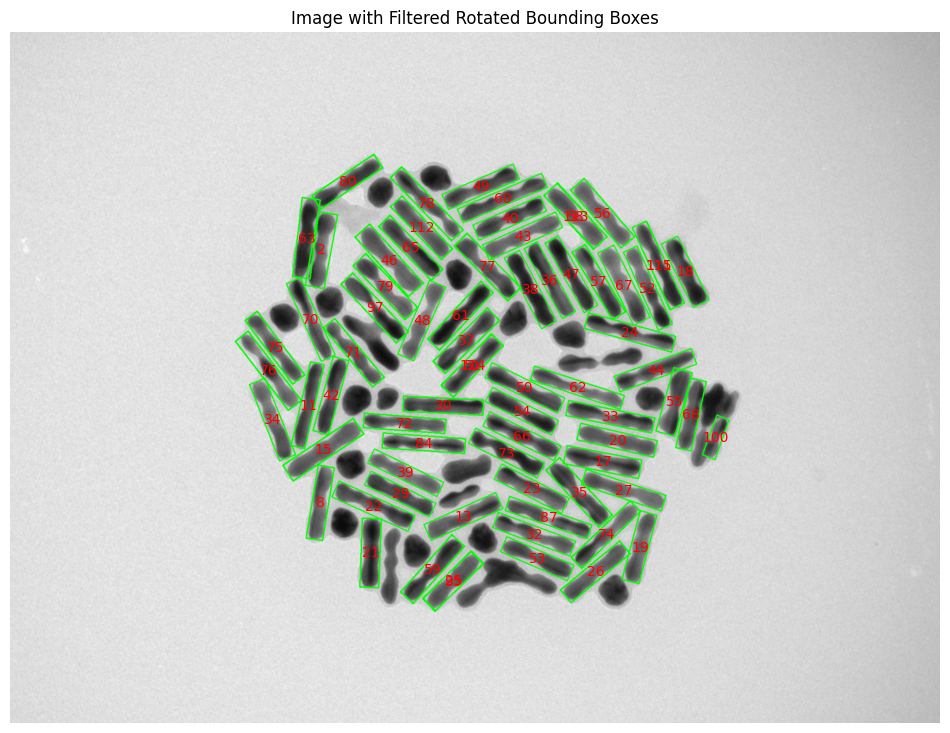

In [11]:
# prompt: a function that takes in a list of rotated bounding boxes 'rotated_bboxes' and an image, plot the bounding boxes on the image where (1) the bounding boxes have aspect ratio > 3,  and (2)  >80% of the pixels in the bounding box is black

import matplotlib.pyplot as plt
import numpy as np
def plot_filtered_rotated_bboxes(rotated_bboxes, image):
    """
    Plots rotated bounding boxes on an image based on aspect ratio and pixel content.

    Args:
        rotated_bboxes (list): A list of tuples, where each tuple represents the
                               Rotated Minimum Bounding Box in the format
                               ((center_x, center_y), (width, height), angle).
        image (np.ndarray): The image on which to plot the bounding boxes (RGB format).
    """
    plt.figure(figsize=(12, 12))
    plt.imshow(image)
    plt.axis('off')

    # Create a copy of the image to draw on
    image_with_bboxes = image.copy()

    roi_list = []
    for i, bbox_data in enumerate(rotated_bboxes):
        ((center_x, center_y), (width, height), angle) = bbox_data

        # 1. Check aspect ratio
        if width > 0 and height > 0:
            aspect_ratio = max(width, height) / min(width, height)
            if aspect_ratio <= 3:
                continue # Skip if aspect ratio is not > 3

        # Get the four corners of the rotated rectangle
        rect = (bbox_data[0], bbox_data[1], bbox_data[2])
        box = cv2.boxPoints(rect)
        box = np.intp(box) # Convert to integer coordinates

        # Extract the region of interest (ROI) defined by the rotated bounding box
        # We need to create a mask for the rotated bounding box to extract the pixels
        # Create a mask of the same size as the image
        mask = np.zeros(image.shape[:2], dtype=np.uint8)
        # Draw the rotated rectangle onto the mask
        cv2.fillPoly(mask, [box], 255)

        # Apply the mask to the image to get the pixels inside the bounding box
        # Ensure image_with_bboxes is in BGR format if using cv2.mean, otherwise use indexing
        # If image is RGB, keep it as is for pixel value check
        pixels_in_bbox = image[mask == 255]

        # 2. Check if >50% of pixels in the bounding box are black
        if pixels_in_bbox.size > 0:
            # Black pixels are typically close to (0, 0, 0) in RGB
            # We can define "black" as pixels where the sum of RGB values is below a threshold
            # Let's use a threshold for each channel, e.g., < 30 for R, G, and B
            black_threshold = 150
            is_black = np.all(pixels_in_bbox < black_threshold, axis=1)
            percentage_black = np.sum(is_black) / pixels_in_bbox.shape[0]

            if percentage_black > 0.5:
                # Plot the bounding box if both conditions are met
                # Draw the rectangle on the image_with_bboxes copy
                cv2.drawContours(image_with_bboxes, [box], 0, (0, 255, 0), 2) # Draw in green
                plt.text(center_x, center_y, s=i, color='red', ha='center', va='center')
                roi_list.append(i)

    # Display the image with the filtered bounding boxes
    plt.imshow(image_with_bboxes)
    plt.title("Image with Filtered Rotated Bounding Boxes")
    plt.show()
    return roi_list

# Example usage:
# Assuming 'rotated_bboxes' is a list of rotated bounding boxes and 'image' is the image
# from the preceding code.
roi_list = plot_filtered_rotated_bboxes(rotated_bboxes, image)

In [49]:
masks_rods = [mask for i, mask in enumerate(masks) if i in roi_list]
bboxs_rods = [bbox for i, bbox in enumerate(rotated_bboxes) if i in roi_list]

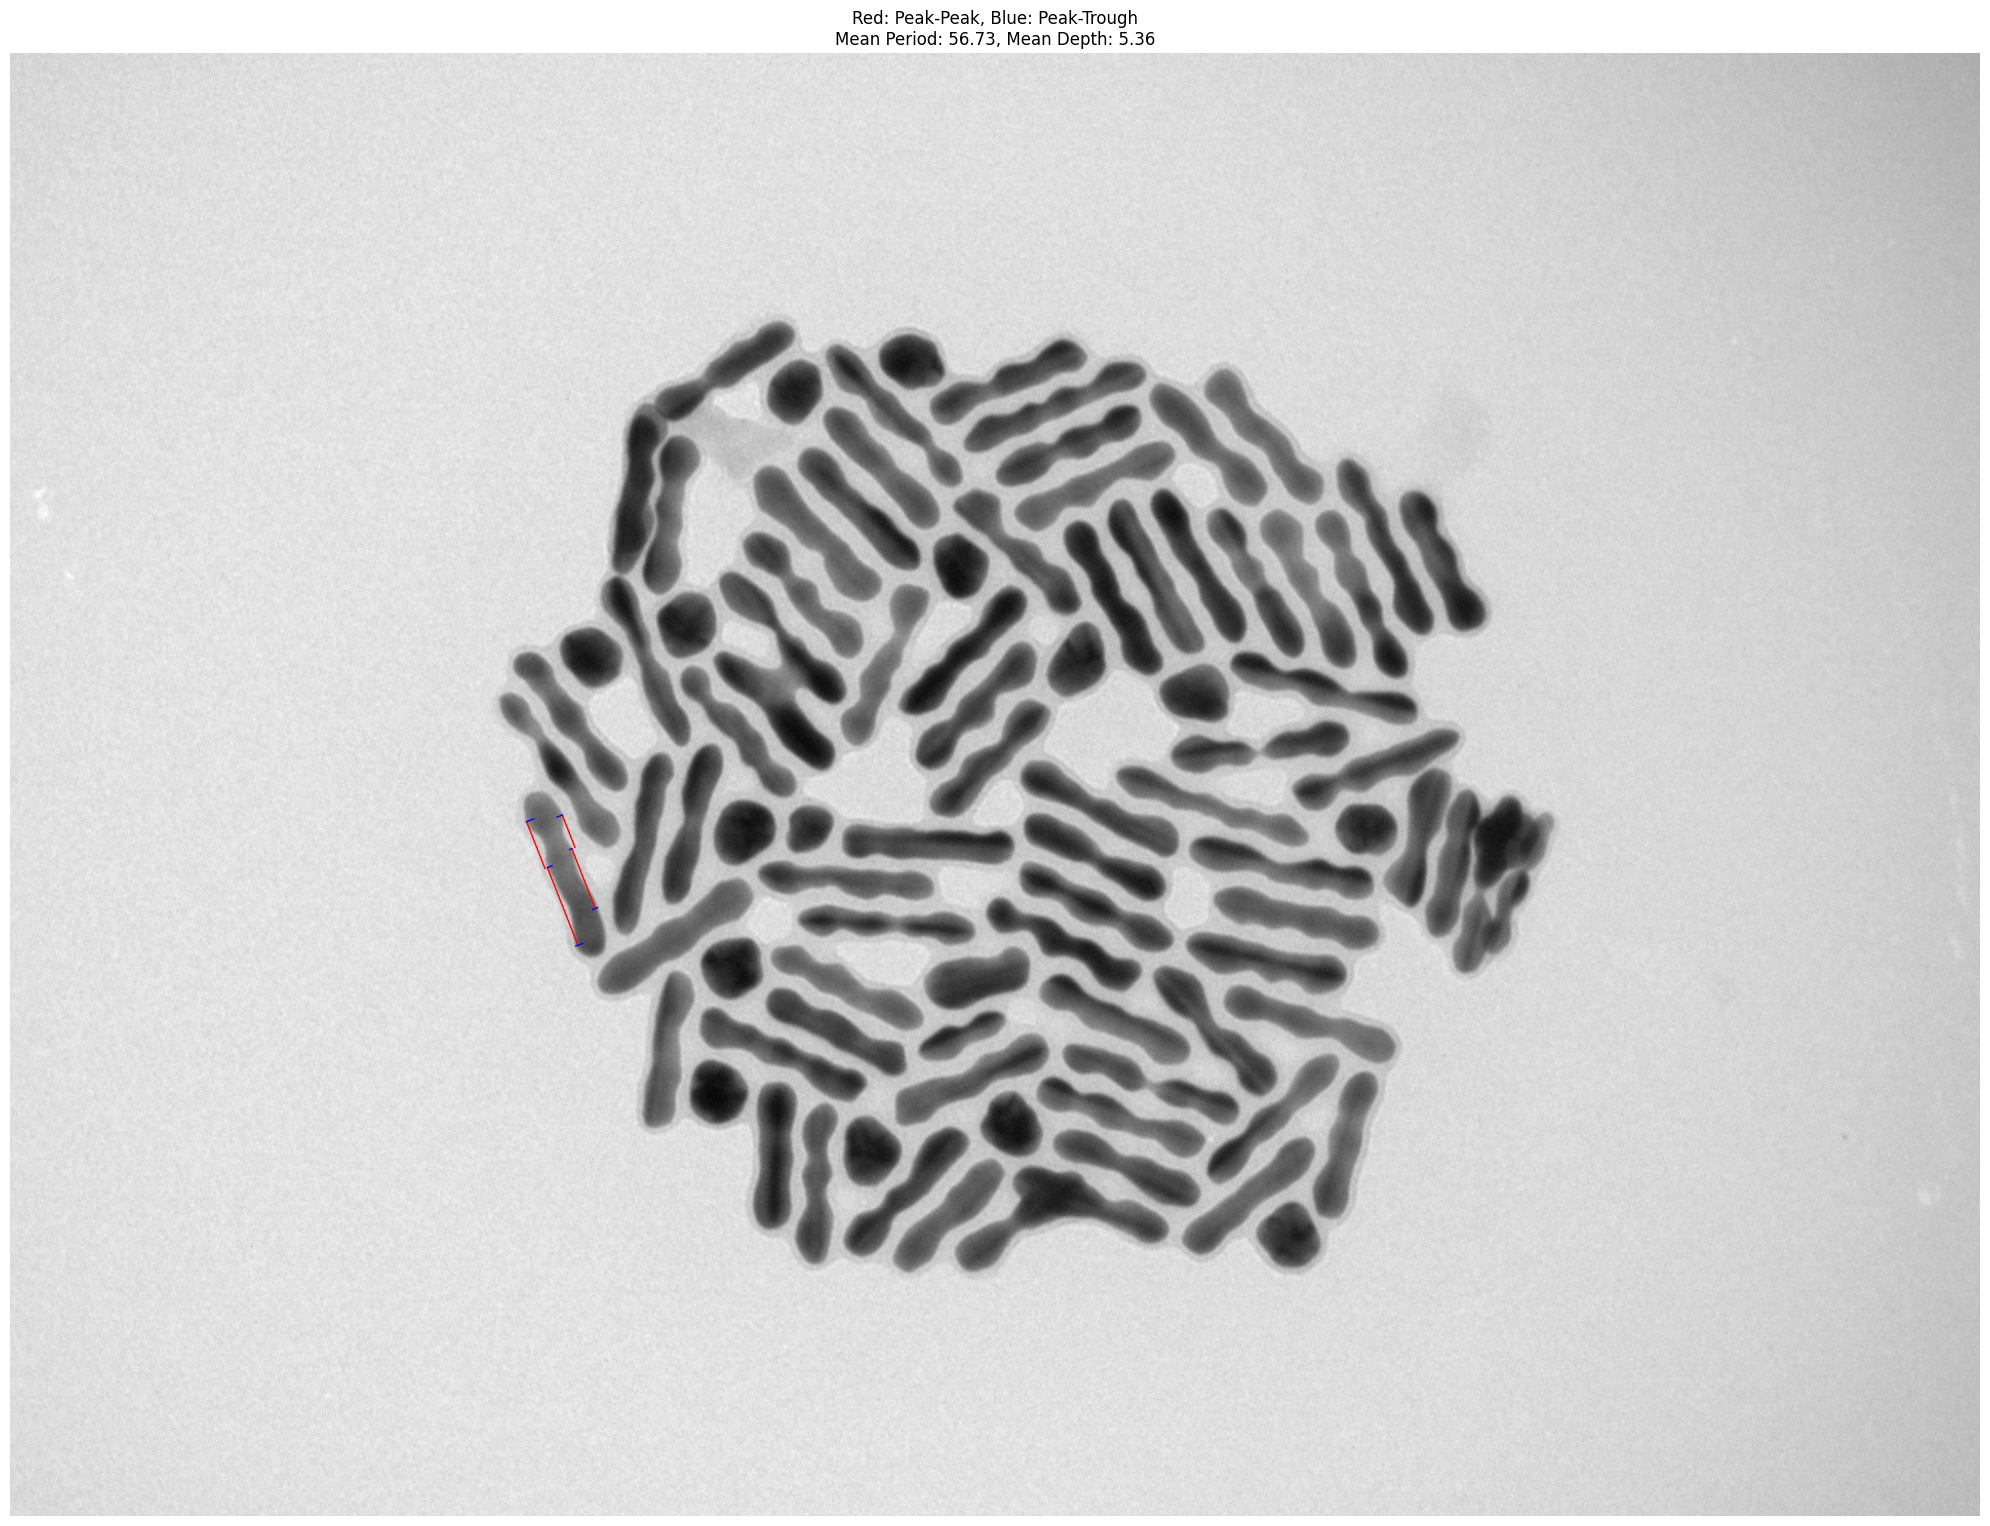

Number of dip periods: 4
Average dip period: 56.73 ± 17.45
Average dip depth: 5.36 ± 1.72


In [45]:
import numpy as np
from skimage.morphology import skeletonize
from sklearn.decomposition import PCA
from scipy.signal import find_peaks

def extract_side_profiles(mask):
    skeleton = skeletonize(mask > 0)
    coords = np.column_stack(np.nonzero(skeleton))
    if len(coords) < 10:
        return None, None, None, None

    # Fit main axis using PCA
    pca = PCA(n_components=2)
    pca.fit(coords[:, ::-1])  # flip to (x, y)

    all_coords = np.column_stack(np.nonzero(mask))
    centered = all_coords[:, ::-1] - pca.mean_
    projected = centered @ pca.components_.T

    # Bin along long axis
    axis_pos = projected[:, 0]
    side_disp = projected[:, 1]
    num_bins = 100
    bins = np.linspace(axis_pos.min(), axis_pos.max(), num_bins + 1)
    bin_centers = []
    left_profile = []
    right_profile = []

    for i in range(num_bins):
        in_bin = (axis_pos >= bins[i]) & (axis_pos < bins[i+1])
        if np.sum(in_bin) > 0:
            vals = side_disp[in_bin]
            left_profile.append(np.min(vals))
            right_profile.append(np.max(vals))
            bin_centers.append(0.5 * (bins[i] + bins[i+1]))

    return np.array(bin_centers), np.array(left_profile), np.array(right_profile), pca

def analyze_and_plot(image, mask):
    bin_centers, left_profile, right_profile, pca = extract_side_profiles(mask)
    if bin_centers is None:
        print("Nanorod too small or poorly shaped.")
        return

    def analyze_profile(profile, bin_centers, side='left', nm_per_pixel=1):
    # Smooth profile
        profile_smooth = cv2.GaussianBlur(profile.astype(np.float32), (5, 1), 0).flatten()

        # Tune peak detection sensitivity
        min_distance = 5        # minimum number of bins between peaks
        min_prominence = 1    # minimum prominence of peaks

        # Detect peaks and troughs
        peaks, _ = find_peaks(profile_smooth, distance=min_distance, prominence=min_prominence)
        troughs, _ = find_peaks(-profile_smooth, distance=min_distance, prominence=min_prominence)

        red_lines = []
        blue_lines = []
        periods = []
        depths = []

        # Decide which to use as primary features based on side
        if side == 'left':
            primary = troughs
            secondary = peaks
        else:
            primary = peaks
            secondary = troughs

        # Red lines: horizontal lines between adjacent primary features (e.g., trough-to-trough)
        for i in range(len(primary) - 1):
            x1 = bin_centers[primary[i]]
            x2 = bin_centers[primary[i + 1]]
            y = profile_smooth[primary[i]]  # or average of y-values if smoother needed

            a = [x1, y]
            b = [x2, y]
            red_lines.append((a, b))

            dist = np.abs(x2 - x1) * nm_per_pixel
            periods.append(dist)

        # Blue lines: vertical from primary feature to closest secondary
        for idx in primary:
            if len(secondary) == 0:
                continue
            distances = np.abs(bin_centers[secondary] - bin_centers[idx])
            nearest_idx = np.argmin(distances)
            sec_idx = secondary[nearest_idx]

            x = bin_centers[idx]
            y1 = profile_smooth[idx]
            y2 = profile_smooth[sec_idx]

            a = [x, y1]
            b = [x, y2]
            blue_lines.append((a, b))

            dist = np.abs(y2 - y1) * nm_per_pixel
            depths.append(dist)

        return red_lines, blue_lines, periods, depths



    # Analyze both sides
    lines_r, lines_b, periods_l, depths_l = analyze_profile(left_profile, bin_centers, 'left')
    lines_r2, lines_b2, periods_r, depths_r = analyze_profile(right_profile, bin_centers, 'right')

    # Combine
    red_lines = lines_r + lines_r2
    blue_lines = lines_b + lines_b2
    all_periods = periods_l + periods_r
    all_depths = depths_l + depths_r

    # Plot
    fig, ax = plt.subplots(figsize=(20, 20))
    ax.imshow(image, cmap='gray')

    # Draw lines
    for (a, b) in red_lines:
        # Convert back to image coords
        p1 = a[0] * pca.components_[0] + a[1] * pca.components_[1] + pca.mean_
        p2 = b[0] * pca.components_[0] + b[1] * pca.components_[1] + pca.mean_
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'r-', linewidth=1)

    for (a, b) in blue_lines:
        p1 = a[0] * pca.components_[0] + a[1] * pca.components_[1] + pca.mean_
        p2 = b[0] * pca.components_[0] + b[1] * pca.components_[1] + pca.mean_
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'b-', linewidth=1)

    ax.set_title(f"Red: Peak-Peak, Blue: Peak-Trough\n"
                 f"Mean Period: {np.mean(all_periods):.2f}, Mean Depth: {np.mean(all_depths):.2f}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Print summary
    print(f"Number of dip periods: {len(all_periods)}")
    print(f"Average dip period: {np.mean(all_periods):.2f} ± {np.std(all_periods):.2f}")
    print(f"Average dip depth: {np.mean(all_depths):.2f} ± {np.std(all_depths):.2f}")

analyze_and_plot(image, masks_rods[20]['segmentation'])

In [14]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    median_area = np.median([ann['area'] for ann in anns])
    for i, ann in enumerate(sorted_anns):
        area = ann['area']
        m = ann['segmentation']
        pos = ann['bbox']
        if area < median_area * 2 and area > median_area / 2:
            color_mask = np.concatenate([np.random.random(3), [0.4]])
            img[m] = color_mask
            ax.text(int(pos[0] + pos[2] / 2), int(pos[1] + pos[3] / 2), s=i, ha='center', va='center')
    ax.imshow(img)

Show all the masks overlayed on the image.

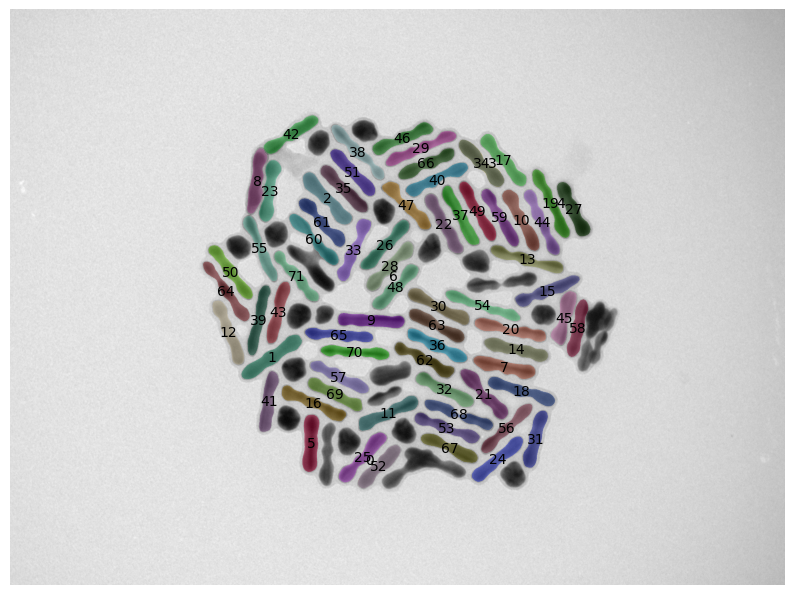

In [15]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks_rods)
plt.axis('off')
plt.show()